In [1]:
# import the necessary packages
from numpy import zeros, ones, expand_dims, asarray
from numpy.random import randn, randint
from keras.datasets import fashion_mnist, mnist, cifar10
from keras.optimizers import Adam
from keras.models import Model, load_model
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import Conv2D, Conv2DTranspose, Concatenate
from keras.layers import LeakyReLU, Dropout, Embedding
from keras.layers import BatchNormalization, Activation
from keras import initializers
from keras.initializers import RandomNormal
from keras.optimizers import Adam, RMSprop, SGD
from matplotlib import pyplot
import numpy as np
from math import sqrt

In [2]:
(X_train, _), (_, _) = mnist.load_data()
X_train = X_train.astype(np.float32) / 255
X_train = np.expand_dims(X_train, axis=3)
print(X_train.shape)

(60000, 28, 28, 1)


In [3]:
def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)  
    z_input = x_input.reshape(n_samples, latent_dim)
    return z_input

In [4]:
def generate_real_samples(X_train, n_samples):
    ix = randint(0, X_train.shape[0], n_samples) 
    X = X_train[ix]  
    y = ones((n_samples, 1)) 
    return X, y

In [5]:
def generate_fake_samples(generator, latent_dim, n_samples):
    z_input = generate_latent_points(latent_dim, n_samples)
    images = generator.predict(z_input)  
    y = zeros((n_samples, 1))
    return images, y

In [6]:
def summarize_performance(step, g_model, latent_dim, n_samples=100):
    X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
    X = (X + 1) / 2.0
    for i in range(100):
        pyplot.subplot(10, 10, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
    filename2 = 'model_%04d.h5' % (step+1)
    g_model.save(filename2)
    print('>Saved: %s' % (filename2))

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def save_plot(examples, n_examples):
    for i in range(n_examples):
        pyplot.subplot(int(sqrt(n_examples)), int(sqrt(n_examples)), 1 + i)
        pyplot.axis('off')
        pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
    pyplot.show()

In [8]:
def define_discriminator(in_shape=(28, 28, 1)):
    init = RandomNormal(stddev=0.02)  
    in_image = Input(shape=in_shape)
    fe = Flatten()(in_image)
    fe = Dense(1024)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.3)(fe)
    fe = Dense(512)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.3)(fe)
    fe = Dense(256)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.3)(fe)
    out = Dense(1, activation='sigmoid')(fe)
    model = Model(in_image, out)
    opt = Adam(lr=0.0002, beta_1=0.5) 
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model
discriminator = define_discriminator()

/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [9]:
def define_generator(latent_dim): 
    init = RandomNormal(stddev=0.02)
    in_lat = Input(shape=(latent_dim,)) 
    gen = Dense(256, kernel_initializer=init)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Dense(512, kernel_initializer=init)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Dense(1024, kernel_initializer=init)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Dense(28 * 28 * 1, kernel_initializer=init)(gen)
    out_layer = Activation('tanh')(gen)
    out_layer = Reshape((28, 28, 1))(gen)
    model = Model(in_lat, out_layer)
    return model
generator = define_generator(100)

/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [10]:
def define_gan(g_model, d_model):
    d_model.trainable = False
    gan_output = d_model(g_model.output)
    model = Model(g_model.input, gan_output)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model
gan_model = define_gan(generator, discriminator)

In [11]:
def train(g_model, d_model, gan_model, X_train, latent_dim, n_epochs=100, n_batch=64):
    bat_per_epo = int(X_train.shape[0] / n_batch)
    n_steps = bat_per_epo * n_epochs
    for i in range(n_steps):
        X_real, y_real = generate_real_samples(X_train, n_batch)
        d_loss_r, d_acc_r = d_model.train_on_batch(X_real, y_real)
        X_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_batch)
        d_loss_f, d_acc_f = d_model.train_on_batch(X_fake, y_fake)
        z_input = generate_latent_points(latent_dim, n_batch) 
        y_gan = ones((n_batch, 1)) 
        g_loss, g_acc = gan_model.train_on_batch(z_input, y_gan)
        print('>%d, dr[%.3f,%.3f], df[%.3f,%.3f], g[%.3f,%.3f]' % (i+1, d_loss_r,d_acc_r, d_loss_f,d_acc_f, g_loss,g_acc))
        if (i+1) % (bat_per_epo * 1) == 0:
            summarize_performance(i, g_model, latent_dim)

2/2 [==============================] - 0s 10ms/step
>1, dr[0.728,0.359], df[0.698,0.094], g[0.690,0.844]
2/2 [==============================] - 0s 9ms/step
>2, dr[0.413,1.000], df[0.709,0.000], g[0.681,1.000]
2/2 [==============================] - 0s 8ms/step
>3, dr[0.238,1.000], df[0.720,0.000], g[0.671,1.000]
2/2 [==============================] - 0s 8ms/step
>4, dr[0.148,1.000], df[0.736,0.000], g[0.659,1.000]
2/2 [==============================] - 0s 11ms/step
>5, dr[0.090,1.000], df[0.758,0.000], g[0.647,1.000]
2/2 [==============================] - 0s 14ms/step
>6, dr[0.065,1.000], df[0.780,0.000], g[0.636,1.000]
2/2 [==============================] - 0s 11ms/step
>7, dr[0.061,1.000], df[0.796,0.000], g[0.622,1.000]
2/2 [==============================] - 0s 9ms/step
>8, dr[0.048,1.000], df[0.825,0.000], g[0.618,1.000]
2/2 [==============================] - 0s 12ms/step
>9, dr[0.036,1.000], df[0.837,0.000], g[0.618,1.000]
2/2 [==============================] - 0s 11ms/step
>10, dr

>Saved: model_0937.h5
2/2 [==============================] - 0s 7ms/step
>938, dr[0.102,0.953], df[0.197,0.922], g[6.130,0.000]
2/2 [==============================] - 0s 8ms/step
>939, dr[0.244,0.891], df[0.244,0.953], g[6.589,0.000]
2/2 [==============================] - 0s 8ms/step
>940, dr[0.438,0.844], df[0.112,0.953], g[4.722,0.031]
2/2 [==============================] - 0s 9ms/step
>941, dr[0.197,0.891], df[0.451,0.812], g[6.792,0.000]
2/2 [==============================] - 0s 11ms/step
>942, dr[0.214,0.906], df[0.046,0.984], g[6.398,0.000]
2/2 [==============================] - 0s 11ms/step
>943, dr[0.280,0.891], df[0.438,0.797], g[7.192,0.000]
2/2 [==============================] - 0s 12ms/step
>944, dr[0.459,0.812], df[0.036,1.000], g[5.127,0.000]
2/2 [==============================] - 0s 7ms/step
>945, dr[0.173,0.938], df[0.403,0.844], g[5.896,0.000]
2/2 [==============================] - 0s 7ms/step
>946, dr[0.319,0.844], df[0.061,1.000], g[5.447,0.000]
2/2 [================

>Saved: model_1874.h5
2/2 [==============================] - 0s 12ms/step
>1875, dr[0.268,0.828], df[0.460,0.781], g[4.827,0.000]
2/2 [==============================] - 0s 15ms/step
>1876, dr[0.369,0.859], df[0.055,1.000], g[4.550,0.000]
2/2 [==============================] - 0s 9ms/step
>1877, dr[0.368,0.797], df[0.481,0.734], g[3.681,0.031]
2/2 [==============================] - 0s 17ms/step
>1878, dr[0.187,0.938], df[0.121,0.969], g[4.673,0.016]
2/2 [==============================] - 0s 15ms/step
>1879, dr[0.446,0.781], df[0.587,0.719], g[4.698,0.016]
2/2 [==============================] - 0s 8ms/step
>1880, dr[0.363,0.797], df[0.068,1.000], g[4.171,0.000]
2/2 [==============================] - 0s 8ms/step
>1881, dr[0.243,0.906], df[0.460,0.844], g[4.175,0.000]
2/2 [==============================] - 0s 11ms/step
>1882, dr[0.300,0.906], df[0.186,0.969], g[3.903,0.031]
2/2 [==============================] - 0s 7ms/step
>1883, dr[0.458,0.781], df[0.350,0.859], g[3.190,0.031]
2/2 [=====

>Saved: model_2811.h5
2/2 [==============================] - 0s 9ms/step
>2812, dr[0.210,0.891], df[0.183,0.984], g[3.494,0.016]
2/2 [==============================] - 0s 8ms/step
>2813, dr[0.219,0.906], df[0.351,0.875], g[4.114,0.000]
2/2 [==============================] - 0s 12ms/step
>2814, dr[0.408,0.781], df[0.157,0.953], g[3.544,0.000]
2/2 [==============================] - 0s 8ms/step
>2815, dr[0.194,0.969], df[0.280,0.844], g[3.681,0.000]
2/2 [==============================] - 0s 8ms/step
>2816, dr[0.353,0.812], df[0.218,0.906], g[3.318,0.000]
2/2 [==============================] - 0s 10ms/step
>2817, dr[0.277,0.875], df[0.323,0.859], g[3.661,0.000]
2/2 [==============================] - 0s 9ms/step
>2818, dr[0.300,0.844], df[0.143,0.969], g[3.467,0.000]
2/2 [==============================] - 0s 11ms/step
>2819, dr[0.195,0.906], df[0.256,0.906], g[3.602,0.000]
2/2 [==============================] - 0s 7ms/step
>2820, dr[0.493,0.781], df[0.236,0.922], g[3.369,0.016]
2/2 [=======

>Saved: model_3748.h5
2/2 [==============================] - 0s 8ms/step
>3749, dr[0.302,0.828], df[0.297,0.906], g[3.112,0.016]
2/2 [==============================] - 0s 13ms/step
>3750, dr[0.268,0.844], df[0.208,0.953], g[2.897,0.031]
2/2 [==============================] - 0s 9ms/step
>3751, dr[0.404,0.781], df[0.250,0.922], g[2.662,0.062]
2/2 [==============================] - 0s 10ms/step
>3752, dr[0.186,0.938], df[0.294,0.906], g[3.183,0.000]
2/2 [==============================] - 0s 9ms/step
>3753, dr[0.320,0.844], df[0.214,0.953], g[3.112,0.031]
2/2 [==============================] - 0s 13ms/step
>3754, dr[0.281,0.828], df[0.288,0.906], g[3.122,0.031]
2/2 [==============================] - 0s 9ms/step
>3755, dr[0.264,0.844], df[0.249,0.953], g[3.004,0.078]
2/2 [==============================] - 0s 7ms/step
>3756, dr[0.190,0.938], df[0.123,0.984], g[3.183,0.047]
2/2 [==============================] - 0s 9ms/step
>3757, dr[0.234,0.875], df[0.405,0.859], g[3.414,0.000]
2/2 [=======

>Saved: model_4685.h5
2/2 [==============================] - 0s 8ms/step
>4686, dr[0.383,0.797], df[0.376,0.766], g[3.274,0.031]
2/2 [==============================] - 0s 9ms/step
>4687, dr[0.374,0.844], df[0.258,0.938], g[3.608,0.031]
2/2 [==============================] - 0s 8ms/step
>4688, dr[0.387,0.844], df[0.234,0.953], g[3.043,0.047]
2/2 [==============================] - 0s 14ms/step
>4689, dr[0.411,0.828], df[0.463,0.781], g[3.173,0.000]
2/2 [==============================] - 0s 10ms/step
>4690, dr[0.291,0.812], df[0.241,0.906], g[3.312,0.000]
2/2 [==============================] - 0s 11ms/step
>4691, dr[0.253,0.859], df[0.302,0.844], g[3.395,0.016]
2/2 [==============================] - 0s 8ms/step
>4692, dr[0.502,0.766], df[0.398,0.844], g[3.290,0.000]
2/2 [==============================] - 0s 9ms/step
>4693, dr[0.442,0.781], df[0.202,0.953], g[3.233,0.000]
2/2 [==============================] - 0s 9ms/step
>4694, dr[0.513,0.812], df[0.419,0.875], g[2.619,0.062]
2/2 [=======

>Saved: model_5622.h5
2/2 [==============================] - 0s 15ms/step
>5623, dr[0.480,0.734], df[0.299,0.875], g[2.351,0.031]
2/2 [==============================] - 0s 12ms/step
>5624, dr[0.584,0.672], df[0.406,0.859], g[2.488,0.031]
2/2 [==============================] - 0s 9ms/step
>5625, dr[0.474,0.750], df[0.389,0.828], g[1.968,0.078]
2/2 [==============================] - 0s 14ms/step
>5626, dr[0.334,0.828], df[0.344,0.906], g[2.256,0.031]
2/2 [==============================] - 0s 11ms/step
>5627, dr[0.543,0.656], df[0.329,0.859], g[2.093,0.094]
2/2 [==============================] - 0s 11ms/step
>5628, dr[0.386,0.781], df[0.504,0.812], g[2.164,0.062]
2/2 [==============================] - 0s 7ms/step
>5629, dr[0.473,0.734], df[0.406,0.875], g[2.012,0.125]
2/2 [==============================] - 0s 10ms/step
>5630, dr[0.552,0.688], df[0.439,0.828], g[2.393,0.031]
2/2 [==============================] - 0s 11ms/step
>5631, dr[0.419,0.781], df[0.266,0.922], g[1.935,0.078]
2/2 [===

>Saved: model_6559.h5
2/2 [==============================] - 0s 9ms/step
>6560, dr[0.421,0.766], df[0.476,0.812], g[2.082,0.047]
2/2 [==============================] - 0s 10ms/step
>6561, dr[0.492,0.719], df[0.395,0.828], g[1.944,0.047]
2/2 [==============================] - 0s 10ms/step
>6562, dr[0.351,0.781], df[0.454,0.812], g[2.127,0.031]
2/2 [==============================] - 0s 15ms/step
>6563, dr[0.535,0.688], df[0.407,0.828], g[2.034,0.094]
2/2 [==============================] - 0s 9ms/step
>6564, dr[0.444,0.766], df[0.324,0.906], g[1.750,0.078]
2/2 [==============================] - 0s 15ms/step
>6565, dr[0.348,0.828], df[0.537,0.719], g[1.919,0.094]
2/2 [==============================] - 0s 10ms/step
>6566, dr[0.577,0.688], df[0.372,0.906], g[2.277,0.047]
2/2 [==============================] - 0s 9ms/step
>6567, dr[0.470,0.703], df[0.379,0.875], g[1.808,0.094]
2/2 [==============================] - 0s 8ms/step
>6568, dr[0.339,0.844], df[0.448,0.797], g[1.908,0.062]
2/2 [=====

>Saved: model_7496.h5
2/2 [==============================] - 0s 13ms/step
>7497, dr[0.382,0.766], df[0.424,0.797], g[2.033,0.031]
2/2 [==============================] - 0s 16ms/step
>7498, dr[0.446,0.781], df[0.403,0.891], g[2.148,0.062]
2/2 [==============================] - 0s 7ms/step
>7499, dr[0.618,0.672], df[0.385,0.859], g[1.888,0.109]
2/2 [==============================] - 0s 8ms/step
>7500, dr[0.386,0.812], df[0.507,0.750], g[2.076,0.000]
2/2 [==============================] - 0s 7ms/step
>7501, dr[0.499,0.688], df[0.409,0.875], g[1.941,0.062]
2/2 [==============================] - 0s 8ms/step
>7502, dr[0.602,0.672], df[0.326,0.938], g[1.697,0.047]
2/2 [==============================] - 0s 9ms/step
>7503, dr[0.297,0.844], df[0.345,0.891], g[1.809,0.047]
2/2 [==============================] - 0s 8ms/step
>7504, dr[0.453,0.734], df[0.301,0.953], g[1.586,0.109]
2/2 [==============================] - 0s 10ms/step
>7505, dr[0.338,0.812], df[0.595,0.766], g[1.674,0.062]
2/2 [=======

>Saved: model_8433.h5
2/2 [==============================] - 0s 9ms/step
>8434, dr[0.519,0.703], df[0.339,0.875], g[1.793,0.047]
2/2 [==============================] - 0s 11ms/step
>8435, dr[0.442,0.812], df[0.506,0.781], g[1.669,0.109]
2/2 [==============================] - 0s 11ms/step
>8436, dr[0.467,0.766], df[0.417,0.859], g[1.748,0.078]
2/2 [==============================] - 0s 10ms/step
>8437, dr[0.430,0.750], df[0.446,0.844], g[1.663,0.062]
2/2 [==============================] - 0s 8ms/step
>8438, dr[0.442,0.750], df[0.306,0.922], g[1.708,0.094]
2/2 [==============================] - 0s 14ms/step
>8439, dr[0.571,0.688], df[0.485,0.797], g[1.722,0.078]
2/2 [==============================] - 0s 12ms/step
>8440, dr[0.458,0.734], df[0.496,0.828], g[1.827,0.094]
2/2 [==============================] - 0s 9ms/step
>8441, dr[0.342,0.766], df[0.454,0.828], g[1.805,0.109]
2/2 [==============================] - 0s 8ms/step
>8442, dr[0.544,0.688], df[0.414,0.859], g[1.949,0.078]
2/2 [=====

>Saved: model_9370.h5
2/2 [==============================] - 0s 11ms/step
>9371, dr[0.431,0.766], df[0.385,0.828], g[1.903,0.031]
2/2 [==============================] - 0s 10ms/step
>9372, dr[0.489,0.734], df[0.444,0.828], g[1.802,0.047]
2/2 [==============================] - 0s 7ms/step
>9373, dr[0.340,0.828], df[0.364,0.859], g[1.960,0.062]
2/2 [==============================] - 0s 8ms/step
>9374, dr[0.451,0.719], df[0.421,0.859], g[1.999,0.078]
2/2 [==============================] - 0s 9ms/step
>9375, dr[0.647,0.641], df[0.320,0.875], g[1.685,0.156]
2/2 [==============================] - 0s 7ms/step
>9376, dr[0.488,0.719], df[0.755,0.672], g[1.871,0.047]
2/2 [==============================] - 0s 14ms/step
>9377, dr[0.724,0.578], df[0.288,0.938], g[1.830,0.094]
2/2 [==============================] - 0s 18ms/step
>9378, dr[0.383,0.766], df[0.478,0.797], g[1.913,0.062]
2/2 [==============================] - 0s 9ms/step
>9379, dr[0.432,0.719], df[0.403,0.828], g[1.851,0.047]
2/2 [======

>Saved: model_10307.h5
2/2 [==============================] - 0s 6ms/step
>10308, dr[0.672,0.594], df[0.403,0.828], g[1.849,0.031]
2/2 [==============================] - 0s 15ms/step
>10309, dr[0.550,0.703], df[0.468,0.781], g[1.811,0.094]
2/2 [==============================] - 0s 9ms/step
>10310, dr[0.489,0.766], df[0.446,0.828], g[1.692,0.062]
2/2 [==============================] - 0s 8ms/step
>10311, dr[0.564,0.703], df[0.421,0.891], g[1.727,0.125]
2/2 [==============================] - 0s 9ms/step
>10312, dr[0.420,0.734], df[0.475,0.781], g[1.996,0.078]
2/2 [==============================] - 0s 7ms/step
>10313, dr[0.537,0.688], df[0.555,0.828], g[1.749,0.109]
2/2 [==============================] - 0s 9ms/step
>10314, dr[0.460,0.766], df[0.376,0.844], g[1.763,0.047]
2/2 [==============================] - 0s 17ms/step
>10315, dr[0.419,0.766], df[0.391,0.828], g[1.583,0.125]
2/2 [==============================] - 0s 11ms/step
>10316, dr[0.469,0.750], df[0.485,0.812], g[1.971,0.047]
2/

>Saved: model_11244.h5
2/2 [==============================] - 0s 12ms/step
>11245, dr[0.465,0.719], df[0.473,0.781], g[1.552,0.156]
2/2 [==============================] - 0s 9ms/step
>11246, dr[0.344,0.812], df[0.445,0.812], g[1.939,0.031]
2/2 [==============================] - 0s 8ms/step
>11247, dr[0.450,0.781], df[0.431,0.859], g[1.938,0.062]
2/2 [==============================] - 0s 15ms/step
>11248, dr[0.553,0.734], df[0.547,0.766], g[1.769,0.141]
2/2 [==============================] - 0s 13ms/step
>11249, dr[0.275,0.906], df[0.383,0.859], g[1.880,0.016]
2/2 [==============================] - 0s 9ms/step
>11250, dr[0.701,0.641], df[0.354,0.844], g[1.692,0.125]
2/2 [==============================] - 0s 11ms/step
>11251, dr[0.428,0.750], df[0.448,0.859], g[1.594,0.125]
2/2 [==============================] - 0s 9ms/step
>11252, dr[0.344,0.812], df[0.561,0.734], g[2.170,0.031]
2/2 [==============================] - 0s 10ms/step
>11253, dr[0.509,0.703], df[0.342,0.891], g[1.920,0.016]


>Saved: model_12181.h5
2/2 [==============================] - 0s 12ms/step
>12182, dr[0.433,0.781], df[0.440,0.844], g[1.869,0.078]
2/2 [==============================] - 0s 8ms/step
>12183, dr[0.560,0.703], df[0.361,0.891], g[1.816,0.078]
2/2 [==============================] - 0s 8ms/step
>12184, dr[0.456,0.719], df[0.434,0.828], g[1.985,0.000]
2/2 [==============================] - 0s 8ms/step
>12185, dr[0.476,0.688], df[0.331,0.922], g[1.839,0.078]
2/2 [==============================] - 0s 10ms/step
>12186, dr[0.500,0.672], df[0.515,0.750], g[1.684,0.109]
2/2 [==============================] - 0s 9ms/step
>12187, dr[0.337,0.859], df[0.393,0.906], g[2.181,0.031]
2/2 [==============================] - 0s 10ms/step
>12188, dr[0.510,0.672], df[0.379,0.891], g[1.897,0.078]
2/2 [==============================] - 0s 9ms/step
>12189, dr[0.491,0.656], df[0.466,0.781], g[1.803,0.031]
2/2 [==============================] - 0s 8ms/step
>12190, dr[0.361,0.781], df[0.376,0.922], g[2.235,0.078]
2/

>Saved: model_13118.h5
2/2 [==============================] - 0s 9ms/step
>13119, dr[0.469,0.781], df[0.406,0.844], g[1.944,0.109]
2/2 [==============================] - 0s 7ms/step
>13120, dr[0.534,0.656], df[0.354,0.875], g[1.678,0.047]
2/2 [==============================] - 0s 10ms/step
>13121, dr[0.282,0.891], df[0.419,0.781], g[1.898,0.078]
2/2 [==============================] - 0s 10ms/step
>13122, dr[0.348,0.844], df[0.378,0.781], g[1.934,0.047]
2/2 [==============================] - 0s 10ms/step
>13123, dr[0.574,0.719], df[0.449,0.812], g[1.722,0.094]
2/2 [==============================] - 0s 7ms/step
>13124, dr[0.383,0.781], df[0.327,0.875], g[1.911,0.031]
2/2 [==============================] - 0s 9ms/step
>13125, dr[0.392,0.781], df[0.516,0.703], g[1.758,0.188]
2/2 [==============================] - 0s 8ms/step
>13126, dr[0.359,0.812], df[0.361,0.922], g[1.997,0.078]
2/2 [==============================] - 0s 18ms/step
>13127, dr[0.419,0.812], df[0.439,0.797], g[2.057,0.031]
2

>Saved: model_14055.h5
2/2 [==============================] - 0s 8ms/step
>14056, dr[0.564,0.688], df[0.431,0.812], g[1.718,0.109]
2/2 [==============================] - 0s 13ms/step
>14057, dr[0.448,0.750], df[0.448,0.812], g[1.980,0.031]
2/2 [==============================] - 0s 14ms/step
>14058, dr[0.427,0.781], df[0.455,0.828], g[2.110,0.062]
2/2 [==============================] - 0s 10ms/step
>14059, dr[0.430,0.734], df[0.375,0.875], g[1.908,0.062]
2/2 [==============================] - 0s 10ms/step
>14060, dr[0.350,0.766], df[0.453,0.828], g[2.062,0.078]
2/2 [==============================] - 0s 9ms/step
>14061, dr[0.540,0.734], df[0.521,0.781], g[1.963,0.031]
2/2 [==============================] - 0s 14ms/step
>14062, dr[0.508,0.672], df[0.362,0.859], g[1.919,0.062]
2/2 [==============================] - 0s 6ms/step
>14063, dr[0.523,0.672], df[0.411,0.844], g[1.883,0.078]
2/2 [==============================] - 0s 8ms/step
>14064, dr[0.367,0.812], df[0.321,0.891], g[1.906,0.047]


>Saved: model_14992.h5
2/2 [==============================] - 0s 19ms/step
>14993, dr[0.437,0.734], df[0.327,0.875], g[1.825,0.062]
2/2 [==============================] - 0s 11ms/step
>14994, dr[0.432,0.781], df[0.415,0.844], g[1.815,0.094]
2/2 [==============================] - 0s 13ms/step
>14995, dr[0.384,0.766], df[0.369,0.891], g[1.866,0.141]
2/2 [==============================] - 0s 9ms/step
>14996, dr[0.374,0.797], df[0.471,0.781], g[2.112,0.062]
2/2 [==============================] - 0s 9ms/step
>14997, dr[0.538,0.719], df[0.300,0.906], g[1.753,0.125]
2/2 [==============================] - 0s 10ms/step
>14998, dr[0.387,0.797], df[0.366,0.875], g[2.041,0.078]
2/2 [==============================] - 0s 13ms/step
>14999, dr[0.251,0.875], df[0.359,0.875], g[1.910,0.109]
2/2 [==============================] - 0s 10ms/step
>15000, dr[0.391,0.828], df[0.321,0.906], g[2.180,0.094]
2/2 [==============================] - 0s 10ms/step
>15001, dr[0.513,0.734], df[0.510,0.844], g[1.919,0.031

>Saved: model_15929.h5
2/2 [==============================] - 0s 13ms/step
>15930, dr[0.405,0.781], df[0.441,0.875], g[2.169,0.000]
2/2 [==============================] - 0s 8ms/step
>15931, dr[0.439,0.703], df[0.358,0.891], g[2.122,0.062]
2/2 [==============================] - 0s 9ms/step
>15932, dr[0.508,0.766], df[0.355,0.875], g[1.892,0.062]
2/2 [==============================] - 0s 8ms/step
>15933, dr[0.348,0.828], df[0.453,0.828], g[2.105,0.016]
2/2 [==============================] - 0s 8ms/step
>15934, dr[0.451,0.766], df[0.375,0.844], g[2.135,0.062]
2/2 [==============================] - 0s 11ms/step
>15935, dr[0.550,0.703], df[0.421,0.781], g[2.172,0.047]
2/2 [==============================] - 0s 17ms/step
>15936, dr[0.336,0.812], df[0.250,0.938], g[2.034,0.031]
2/2 [==============================] - 0s 14ms/step
>15937, dr[0.375,0.781], df[0.438,0.812], g[1.815,0.109]
2/2 [==============================] - 0s 13ms/step
>15938, dr[0.459,0.781], df[0.311,0.906], g[1.998,0.078]


>Saved: model_16866.h5
2/2 [==============================] - 0s 18ms/step
>16867, dr[0.364,0.812], df[0.440,0.766], g[2.098,0.078]
2/2 [==============================] - 0s 13ms/step
>16868, dr[0.369,0.797], df[0.353,0.891], g[2.118,0.031]
2/2 [==============================] - 0s 11ms/step
>16869, dr[0.534,0.734], df[0.377,0.797], g[1.848,0.078]
2/2 [==============================] - 0s 8ms/step
>16870, dr[0.437,0.797], df[0.448,0.828], g[1.825,0.078]
2/2 [==============================] - 0s 9ms/step
>16871, dr[0.565,0.734], df[0.524,0.750], g[2.118,0.078]
2/2 [==============================] - 0s 10ms/step
>16872, dr[0.469,0.688], df[0.373,0.875], g[2.155,0.047]
2/2 [==============================] - 0s 11ms/step
>16873, dr[0.395,0.781], df[0.326,0.844], g[2.373,0.031]
2/2 [==============================] - 0s 8ms/step
>16874, dr[0.465,0.750], df[0.395,0.875], g[2.164,0.094]
2/2 [==============================] - 0s 12ms/step
>16875, dr[0.435,0.781], df[0.401,0.812], g[2.118,0.094]

>Saved: model_17803.h5
2/2 [==============================] - 0s 15ms/step
>17804, dr[0.484,0.766], df[0.364,0.906], g[1.944,0.062]
2/2 [==============================] - 0s 9ms/step
>17805, dr[0.346,0.828], df[0.532,0.859], g[2.173,0.031]
2/2 [==============================] - 0s 8ms/step
>17806, dr[0.549,0.719], df[0.259,0.938], g[1.938,0.016]
2/2 [==============================] - 0s 15ms/step
>17807, dr[0.456,0.781], df[0.297,0.891], g[2.021,0.109]
2/2 [==============================] - 0s 9ms/step
>17808, dr[0.377,0.781], df[0.557,0.688], g[1.834,0.156]
2/2 [==============================] - 0s 11ms/step
>17809, dr[0.490,0.703], df[0.452,0.812], g[1.975,0.047]
2/2 [==============================] - 0s 18ms/step
>17810, dr[0.651,0.625], df[0.352,0.859], g[1.813,0.094]
2/2 [==============================] - 0s 20ms/step
>17811, dr[0.594,0.656], df[0.341,0.875], g[1.938,0.016]
2/2 [==============================] - 0s 16ms/step
>17812, dr[0.368,0.781], df[0.619,0.703], g[1.779,0.078]

>Saved: model_18740.h5


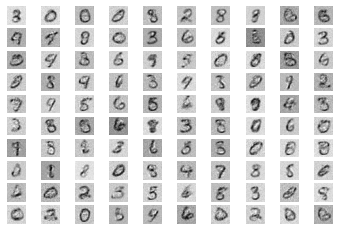

In [12]:
latent_dim = 100
train(generator, discriminator, gan_model, X_train, latent_dim, n_epochs=20, n_batch=64)

4/4 [==============================] - 0s 5ms/step


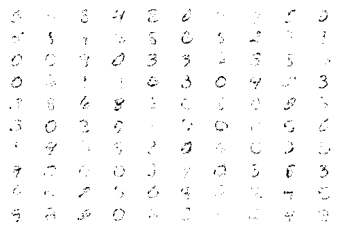

In [13]:
model = load_model('model_18740.h5')
latent_dim = 100
n_examples = 100
latent_points = generate_latent_points(latent_dim, n_examples)
X  = model.predict(latent_points)
X = (X + 1) / 2
X = X.astype('int')
save_plot(X, n_examples)